In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Derin Ogrenme Kullanarak Ses Sinyali Sınıflandırması

### Ses sinyallerini analiz etmek ve bunların MFCC'lerini çıkartmak. Yani ses verisinden o ses verisini karakterize edecek bir takım bilgileri çıkartmamızı sağlıyor

### 3 ana bölümümüz olacak



### 1- Datasetimizi indiricez. MFCC kullanarak ses dosyalarının ozelliklerini cikaracagiz

### 2- Deep Learning modeli olusturma ve ses dosyalarinin classification yapma. CNN modeli olusturucaz ve datasetimizi kullanarak train edecegiz.

### 3- Ornek bir ses dosyasini predict etmeye calisicaz

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os       
import librosa
import numpy as np
from tqdm import tqdm    #progress bar
from sklearn.model_selection import train_test_split  #dizilerimizi veya matrislerimizi rastgele test datalarına dönüştürme
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder  # kategorik değişkenlerin tahminlerde kullanılabilmesi için makine öğrenmesi algoritmalarına uygun bir forma dönüştürüldüğü bir süreçte kullanılmaktadır
from tensorflow.keras.models import Sequential  #Katman ile bir model katman oluşturmanıza izin verir
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
# Dense: Katmanlar arasında nöron ya da düğümlerin geçişlerini sağlar
# Dropout: Eğitim sırasında aşırı öğrenmeyi(overfitting) engellemek için bazı nöronları unutmak için kullanılanılır
# Activation: y değerini kontrol etmek için yani bir nöronun aktif olup olmayacağına karar vermek için kullanılmaktadır
# Flatten: Girişi düzleştirir
from tensorflow.keras.optimizers import Adam
from sklearn import metrics #bir modelin başarısını ölçmek için çok kullanılan ancak tek başına yeterli olmayan metrik
from tensorflow.keras.callbacks import ModelCheckpoint # bir modeli veya ağırlıkları belirli aralıklarla kaydetmek 
from datetime import datetime #zaman, saat ve tarihlerle ilgili işlemler

Librosa bir ses analiz kutuphanesidir. Muzik ve ses analizi için kullanılan bir 
python paketidir.

In [ ]:
import librosa
librosa.feature.melspectrogram

<function librosa.feature.spectral.melspectrogram>

In [ ]:
audio_file_path = '/content/drive/MyDrive/SesDeepLearning/20285-3-2-0.wav'
librosa_audio_data, librosa_sample_rate=librosa.load(audio_file_path)

In [ ]:
print(librosa_audio_data)

[7.0313537e-05 7.7927580e-05 7.2544957e-05 ... 5.7746696e-05 7.2674404e-05
 0.0000000e+00]


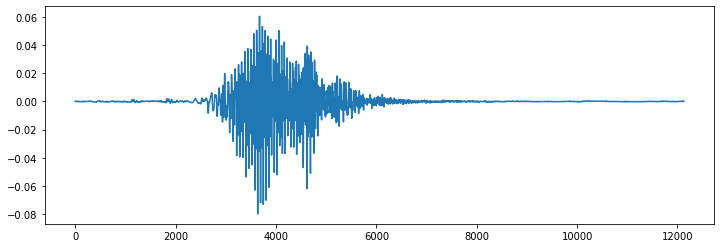

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(librosa_audio_data)
plt.show()

In [ ]:
from scipy.io import wavfile as wav
wave_simple_rate, wave_audio = wav.read(audio_file_path)

In [ ]:
wave_audio

array([[6, 0],
       [6, 0],
       [4, 0],
       ...,
       [1, 2],
       [3, 3],
       [4, 3]], dtype=int16)

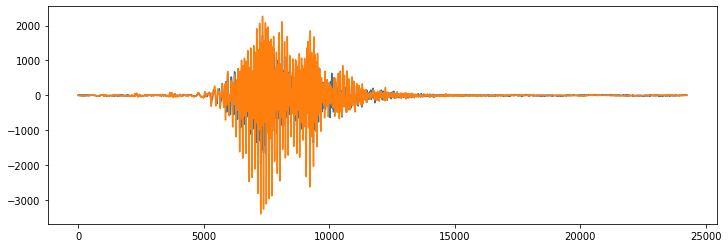

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(wave_audio)
plt.show()

## Ozellik Cikartma

In [ ]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 24)


In [ ]:
mfccs

array([[-7.53620422e+02, -7.36460327e+02, -7.13210083e+02,
        -6.94660400e+02, -6.54094482e+02, -4.66684326e+02,
        -3.39147339e+02, -2.98089020e+02, -3.07100403e+02,
        -3.09425079e+02, -3.47498901e+02, -4.14199860e+02,
        -5.00709106e+02, -5.79867798e+02, -6.36588928e+02,
        -6.77790222e+02, -7.12989868e+02, -7.39400635e+02,
        -7.67599792e+02, -7.75242432e+02, -7.74569702e+02,
        -7.89309143e+02, -7.86815002e+02, -7.81422913e+02],
       [ 8.87546768e+01,  1.05198303e+02,  1.29252014e+02,
         1.44139587e+02,  1.69527710e+02,  1.86269562e+02,
         1.55957733e+02,  1.22635544e+02,  1.11013809e+02,
         1.30002197e+02,  1.28923996e+02,  1.33873077e+02,
         1.39808105e+02,  1.37109833e+02,  1.35257477e+02,
         1.24779854e+02,  1.11343063e+02,  9.65314331e+01,
         7.75556870e+01,  7.28507385e+01,  6.95871429e+01,
         5.14442062e+01,  5.45369911e+01,  5.79232330e+01],
       [ 4.00788956e+01,  4.73406296e+01,  5.65225029e

## Yukarıda yaptığımız sadece 1 ses dosyasına ait idi. Şimdi bütün ses dosyalarına yapalım

In [ ]:
audio_dataset_path = '/content/drive/MyDrive/SesDeepLearning/UrbanSound8K/audio'
metadata = pd.read_csv('/content/drive/MyDrive/SesDeepLearning/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)  
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)   
    return mfccs_scaled_features

In [ ]:
extracted_features=[]
for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), 'fold'+str(row["fold"])+'/', str(row["slice_file_name"]))
    final_class_labels = row["class"]
    data = features_extractor(file_name)
    extracted_features.append([data, final_class_labels])

3555it [06:00,  9.75it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
8324it [13:27, 14.86it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
8329it [13:27, 22.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]
8732it [14:08, 10.29it/s]


In [ ]:
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
extracted_features_df.head()

,feature,class
0,"[-215.79301, 71.66612, -131.81377, -52.09133, ...",dog_bark
1,"[-424.68677, 110.56227, -54.148235, 62.01074, ...",children_playing
2,"[-459.56467, 122.800354, -47.92471, 53.265705,...",children_playing
3,"[-414.55377, 102.896904, -36.66495, 54.18041, ...",children_playing
4,"[-447.397, 115.0954, -53.809113, 61.60859, 1.6...",children_playing


In [ ]:
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())

In [ ]:
X

array([[-2.15793015e+02,  7.16661224e+01, -1.31813766e+02, ...,
        -1.68275905e+00, -8.85858238e-01,  3.54388624e-01],
       [-4.24686768e+02,  1.10562271e+02, -5.41482353e+01, ...,
         6.17408633e-01, -6.84974074e-01,  5.71514428e-01],
       [-4.59564667e+02,  1.22800354e+02, -4.79247093e+01, ...,
         2.22541404e+00,  1.54661798e+00, -8.36315691e-01],
       ...,
       [-3.04613159e+02,  1.12619904e+02, -4.71619453e+01, ...,
        -3.03358078e+00,  2.71057296e+00,  7.67189503e+00],
       [-3.44714233e+02,  1.26758141e+02, -5.61771698e+01, ...,
        -7.80225849e+00, -1.77907360e+00,  5.83541918e+00],
       [-3.15933838e+02,  9.56758881e+01, -3.80477676e+01, ...,
         5.77580512e-01, -1.14637651e+01, -5.96535349e+00]], dtype=float32)

In [ ]:
X.shape

(8732, 40)

In [ ]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [ ]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [ ]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
y[1]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 0)

In [ ]:
X_train

array([[-1.3183614e+02,  1.1397464e+02, -2.3956861e+01, ...,
         3.3314774e+00, -1.4786111e+00,  2.8736601e+00],
       [-1.4074220e+01,  9.1916939e+01, -8.6787205e+00, ...,
        -3.3844025e+00, -5.2119040e+00, -1.5936139e+00],
       [-4.9532028e+01,  1.5521857e-01, -2.0369110e+01, ...,
         2.0491767e+00, -8.0537486e-01,  2.7793026e+00],
       ...,
       [-4.2699329e+02,  9.2890648e+01,  3.0233369e+00, ...,
         8.6335993e-01,  6.4766800e-01,  7.8490508e-01],
       [-1.4607024e+02,  1.3709459e+02, -3.4298344e+01, ...,
         1.3777871e+00, -1.9530842e+00, -8.9652115e-01],
       [-4.2167450e+02,  2.1169032e+02,  2.6820304e+00, ...,
        -5.1484952e+00, -3.6400859e+00, -1.3321606e+00]], dtype=float32)

In [ ]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
X_train.shape

(6985, 40)

In [ ]:
X_test.shape

(1747, 40)

In [ ]:
y_train.shape

(6985, 10)

In [ ]:
y_test.shape

(1747, 10)

**CNN Modeli Oluşturma**

In [ ]:
from sklearn import metrics

In [ ]:
# 10 farklı sınıf olduğu için
num_labels = 10

In [ ]:
model = Sequential()

# 1. hidden layer
model.add(Dense(250, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 2. hidden layer
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 3. hidden layer
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#output layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))


In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 250)               10250     
                                                                 
 activation_28 (Activation)  (None, 250)               0         
                                                                 
 dropout_21 (Dropout)        (None, 250)               0         
                                                                 
 dense_29 (Dense)            (None, 250)               62750     
                                                                 
 activation_29 (Activation)  (None, 250)               0         
                                                                 
 dropout_22 (Dropout)        (None, 250)               0         
                                                                 
 dense_30 (Dense)            (None, 300)              

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
epochscount = 200
num_batch_size = 32

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=epochscount, validation_data=(X_test, y_test), verbose=1)

Epoch 1/200
219/219 [==============================] - 3s 6ms/step - loss: 8.4530 - accuracy: 0.1559 - val_loss: 2.1538 - val_accuracy: 0.2044
Epoch 2/200
219/219 [==============================] - 1s 5ms/step - loss: 2.4224 - accuracy: 0.1928 - val_loss: 2.1286 - val_accuracy: 0.2221
Epoch 3/200
219/219 [==============================] - 1s 5ms/step - loss: 2.1640 - accuracy: 0.2415 - val_loss: 2.0231 - val_accuracy: 0.2948
Epoch 4/200
219/219 [==============================] - 1s 5ms/step - loss: 2.0066 - accuracy: 0.2945 - val_loss: 1.8674 - val_accuracy: 0.3572
Epoch 5/200
219/219 [==============================] - 1s 5ms/step - loss: 1.8990 - accuracy: 0.3307 - val_loss: 1.7397 - val_accuracy: 0.4064
Epoch 6/200
219/219 [==============================] - 1s 5ms/step - loss: 1.7615 - accuracy: 0.3834 - val_loss: 1.5705 - val_accuracy: 0.4991
Epoch 7/200
219/219 [==============================] - 1s 5ms/step - loss: 1.6712 - accuracy: 0.4261 - val_loss: 1.4612 - val_accuracy: 0.5501

In [ ]:
validation_test_set_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(validation_test_set_accuracy[1])

0.8517458438873291


In [ ]:
X_test[1]

array([-466.1843    ,    1.5388287 ,  -34.397358  ,   35.715336  ,
        -15.16693   ,  -18.850813  ,   -0.7415814 ,  -15.999888  ,
        -21.354332  ,    7.650683  ,  -29.03145   ,  -19.142824  ,
         -2.6798913 ,   -8.466883  ,  -14.7660475 ,   -7.004778  ,
         -7.103754  ,    8.887754  ,   14.911873  ,   21.47102   ,
         21.336626  ,    0.9169517 ,  -18.795404  ,   -5.001721  ,
         -0.70152706,    2.9139898 ,   -6.710599  ,  -16.638536  ,
         -9.821647  ,   12.8619585 ,    0.6552978 ,  -23.953394  ,
        -15.200551  ,    9.210791  ,   10.419799  ,   -0.57916135,
         -1.2440345 ,   17.722294  ,   13.837573  ,   -5.164349  ],
      dtype=float32)

In [ ]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

### CNN modeli kullanarak  bir ses dosyasının sınıfını tahmin ediyoruz

In [ ]:
filename = "/content/drive/MyDrive/SesDeepLearning/kopek.wav"
sound_signal, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfcc_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
mfcc_scaled_features = np.mean(mfcc_features.T, axis=0)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
print(mfcc_scaled_features)

[-3.7535922e+02  8.9425331e+01  1.8051803e+00 -2.2050151e-01
 -2.2829998e+00  1.2133409e+01  3.0768154e+00  7.3222136e+00
  3.0560772e+00  5.7430167e+00  3.0821548e+00  3.8009739e+00
  2.3181927e+00  3.2125416e+00  4.1304245e+00  6.2325034e+00
  5.5268202e+00  3.8131726e+00  1.7324582e+00  3.5253352e-01
  1.2011662e+00  1.2637385e+00  2.5038927e+00 -1.6482855e-01
  1.5680116e+00  1.4039514e+00  2.4148483e+00  5.8323461e-01
  1.9324719e+00  2.9373257e+00  2.6547399e+00  1.4445925e+00
  1.8478597e+00  2.4215407e+00  1.3687174e+00  1.6195971e+00
  7.9822928e-01  8.7262505e-01  5.7375866e-01  1.1610743e+00]


In [ ]:
mfcc_scaled_features = mfcc_scaled_features.reshape(1,-1)

In [ ]:
mfcc_scaled_features.shape

(1, 40)

In [ ]:
result_array = model.predict(mfcc_scaled_features)

In [ ]:
result_array
result_classes = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

result = np.argmax(result_array[0])
print(result_classes[result])

dog_bark
